In [1]:
# import

# packages
import pandas as pd
import pyarrow.dataset as ds
from datasets import Dataset
import pyarrow as pa
from datasets import *
from transformers import *
from tokenizers import *
import os
import json
import sys
from tokenizers.processors import BertProcessing
import numpy as np

C:\Users\XinZhou\anaconda3\envs\dna\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\XinZhou\anaconda3\envs\dna\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
# INPORTANT
# out_dir = './task_devign_v3'
# raw_data_path = '/scratch/xin/devign_task/tokenized_devign_v3.pkl'
MAX_LENGTH = 1024
batch_size = 6
# model_path = '/scratch/xin/bert_source_v3/pretrained-bert/'

num_epochs = 3
max_step_saves = 5
save_step_at = 500
test_only = False
data_name = 'mvdsc'
truncate_longer_samples = True

is_windows = sys.platform.startswith('win')

if is_windows:
    data_dir = "..\\..\\cbert\\tasks_usage\\{}".format(data_name)
    bert_model_path = '..\\..\\cbert\\pretrained\\RoBERTa_usage\\checkpoint-50000'
    out_dir = 'result_{}'.format(data_name)
    tokenizer_path = '..\\..\\cbert\\pretrained\\roberta_usage'

# load data
def get_data(file_path):
    raw_df = pd.read_pickle(file_path)  
    df = {'filename': [], 'text': [], 'label': []}
    for i in range(len(raw_df['code'])):
        df['filename'].append(raw_df['filename'][i])
        code = raw_df['code'][i].split(';')
        code = ' '.join(code)
        df['text'].append(code)
        df['label'].append(raw_df['label'][i])
    df = pd.DataFrame(df)
    return df


In [3]:
# train_data = get_data('/scratch/xin/bert_source/mvdsc/tokenized_mvdsc_train.pkl')
# valid_data = get_data('/scratch/xin/bert_source/mvdsc/tokenized_mvdsc_valid.pkl')
if data_name == 'devign':
    raw_data_path = os.path.join(data_dir, 'devign_all.pkl')
    tokenized_data = get_data(raw_data_path)
    train_data, valid_data, test_data = np.split(tokenized_data.sample(frac=1, random_state=2022), 
                   [int(.8*len(tokenized_data)), int(.9*len(tokenized_data))])
elif data_name == 'mvdsc':
    raw_data_path = os.path.join(data_dir, 'mvdsc_mix_train.pkl')
    train_data = get_data(raw_data_path)
    raw_data_path = os.path.join(data_dir, 'mvdsc_mix_valid.pkl')
    valid_data = get_data(raw_data_path)
    raw_data_path = os.path.join(data_dir, 'mvdsc_mix_test.pkl')
    test_data = get_data(raw_data_path)
    


In [4]:
from sklearn.model_selection import train_test_split

print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)
print(train_data['text'][:10])

(38000, 3)
(8500, 3)
(8500, 3)
0    void CWE121_Stack_Based_Buffer_Overflow__src_c...
1    void CWE121_Stack_Based_Buffer_Overflow__src_c...
2    void CWE121_Stack_Based_Buffer_Overflow__src_c...
3    void CWE121_Stack_Based_Buffer_Overflow__src_c...
4    void CWE121_Stack_Based_Buffer_Overflow__src_c...
5    void CWE121_Stack_Based_Buffer_Overflow__src_c...
6    void CWE121_Stack_Based_Buffer_Overflow__src_c...
7    void CWE121_Stack_Based_Buffer_Overflow__src_c...
8    void CWE121_Stack_Based_Buffer_Overflow__src_c...
9    void CWE121_Stack_Based_Buffer_Overflow__src_c...
Name: text, dtype: object


In [5]:
label_counts = pd.DataFrame(train_data['label'].value_counts())
label_counts
label_values = list(label_counts.index)
order = list(pd.DataFrame(train_data['label'].value_counts()).index)
label_values = [l for _,l in sorted(zip(order, label_values))]
label_values

[0, 1]

In [6]:
train_texts = train_data['text'].values
train_labels = train_data['label'].values

valid_texts = valid_data['text'].values
valid_labels = valid_data['label'].values

test_texts = test_data['text'].values
test_labels = test_data['label'].values

print(train_texts)

['void CWE121_Stack_Based_Buffer_Overflow__src_char_declare_cpy_01_bad ( ) { char * charPointerDefUsePass   char charDefCall [ 6 5 6 ]   charPointerDefUsePass = charDefCall   memset ( charPointerDefUsePass , \' A \' , 3 1 6 )   charPointerDefUsePass [ 5 7 1 ] = \' \\0 \'   charPointerDefUsePass [ 4 4 9 ] = \' \'   charPointerDefUsePass [ 3 5 7 ] = \' \'   charPointerDefUsePass [ 8 1 ] = \' \'   charPointerDefUsePass [ 4 0 3 ] = \' \'   charPointerDefUsePass [ 1 4 2 ] = \' \'   charPointerDefUsePass [ 3 6 5 ] = \' \'   charPointerDefUsePass [ 6 9 ] = \' \'   charPointerDefUsePass [ 9 ] = \' \'   charPointerDefUsePass [ 1 9 7 ] = \' \'   charPointerDefUsePass [ 3 9 6 ] = \' \'   charPointerDefUsePass [ 4 7 7 ] = \' \'   charPointerDefUsePass [ 5 1 4 ] = \' \'   charPointerDefUsePass [ 2 2 2 ] = \' \'   charPointerDefUsePass [ 8 8 ] = \' \'   charPointerDefUsePass [ 5 4 5 ] = \' \'   charPointerDefUsePass [ 5 0 8 ] = \' \'   charPointerDefUsePass [ 1 2 7 ] = \' \'   charPointerDefUsePass 

In [7]:
import statistics
train_texts[0]
text_lengths = [len(train_texts[i].split()) for i in range(len(train_texts))]
print('min: ', min(text_lengths))
print('number of zeros: ', len([item for item in text_lengths if item == 0]))
print('max: ', max(sorted(text_lengths)))
print('avg: ', sum(text_lengths) / len(text_lengths))
print('median: ', sorted(text_lengths)[len(text_lengths) // 2])
print('95%: ', sorted(text_lengths)[int(len(text_lengths)*0.95)])
print(statistics.mean(text_lengths))
print(statistics.stdev(text_lengths))

min:  10
number of zeros:  0
max:  4970
avg:  254.98373684210526
median:  143
95%:  862
254.98373684210526
253.67874560135567


C:\Users\XinZhou\AppData\Local\Temp\ipykernel_18768\2095679928.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(text_lengths, hist=True, kde=False,


Text(0, 0.5, 'counts')

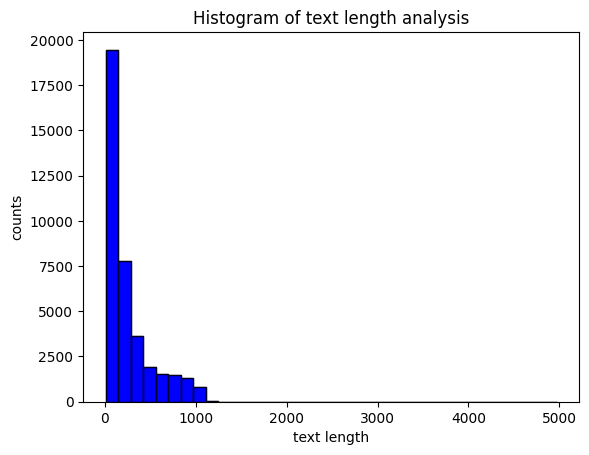

In [8]:
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns
# matplotlib histogram
plt.hist(text_lengths, color = 'blue', edgecolor = 'black',
         bins = int(180/5))
# seaborn histogram
sns.distplot(text_lengths, hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of text length analysis')
plt.xlabel('text length')
plt.ylabel('counts')

In [9]:
sum([1 for i in range(len(text_lengths)) if text_lengths[i] >= MAX_LENGTH])

466

In [10]:
# ========================= load tokenizer START =========================
# 30,522 vocab is BERT's default vocab size, feel free to tweak
vocab_size = 50_000
# maximum sequence length, lowering will result to faster training (when increasing batch size)
# max_length = 512 # 768
from transformers import RobertaTokenizerFast
print(tokenizer_path)
tokenizer = RobertaTokenizerFast.from_pretrained(tokenizer_path, max_len=512)
print('tokenizer loaded ...')
# ========================= load tokenizer END =========================



Didn't find file ..\..\cbert\pretrained\roberta_usage\tokenizer.json. We won't load it.
Didn't find file ..\..\cbert\pretrained\roberta_usage\added_tokens.json. We won't load it.
Didn't find file ..\..\cbert\pretrained\roberta_usage\special_tokens_map.json. We won't load it.
Didn't find file ..\..\cbert\pretrained\roberta_usage\tokenizer_config.json. We won't load it.
loading file ..\..\cbert\pretrained\roberta_usage\vocab.json
loading file ..\..\cbert\pretrained\roberta_usage\merges.txt
loading file None
loading file None
loading file None
loading file None
loading configuration file ..\..\cbert\pretrained\roberta_usage\config.json
Model config RobertaConfig {
  "BOS_token": "<s>",
  "EOS": "</s>",
  "_name_or_path": "..\\..\\cbert\\pretrained\\roberta_usage",
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "do_lower_case": false,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_

..\..\cbert\pretrained\roberta_usage
tokenizer loaded ...


In [11]:
# text_ids = [tokenizer.encode(text, max_length=300, pad_to_max_length=True) for text in texts]
if not truncate_longer_samples:
    #tokenizer(examples["text"], return_special_tokens_mask=True)
    train_text_dict = [tokenizer(t, return_special_tokens_mask=True) for t in train_texts]
    valid_text_dict = [tokenizer(t, return_special_tokens_mask=True) for t in valid_texts]
    test_text_dict = [tokenizer(t, return_special_tokens_mask=True) for t in test_texts]
else:
    max_length = MAX_LENGTH
    train_text_dict = [tokenizer(t, truncation=True, padding="max_length", max_length=max_length, return_special_tokens_mask=True) for t in train_texts]
    valid_text_dict = [tokenizer(t, truncation=True, padding="max_length", max_length=max_length, return_special_tokens_mask=True) for t in valid_texts]
    test_text_dict = [tokenizer(t, truncation=True, padding="max_length", max_length=max_length, return_special_tokens_mask=True) for t in test_texts]

In [12]:
train_text_ids = [text_id['input_ids'] for text_id in train_text_dict]
valid_text_ids = [text_id['input_ids'] for text_id in valid_text_dict]
test_text_ids = [text_id['input_ids'] for text_id in test_text_dict]
# text_ids[0]
train_att_masks = [text_id['attention_mask'] for text_id in train_text_dict]
valid_att_masks = [text_id['attention_mask'] for text_id in valid_text_dict]
test_att_masks = [text_id['attention_mask'] for text_id in test_text_dict]
# att_masks[0]

In [13]:
from sklearn.model_selection import train_test_split
train_x, train_m, train_y = train_text_ids, train_att_masks, train_labels
val_x, val_m, val_y = valid_text_ids, valid_att_masks, valid_labels
test_x, test_m, test_y = test_text_ids, test_att_masks, test_labels

In [14]:
import torch

train_x = torch.tensor(train_x)
test_x = torch.tensor(test_x)
val_x = torch.tensor(val_x)
train_y = torch.tensor(train_y)
test_y = torch.tensor(test_y)
val_y = torch.tensor(val_y)
train_m = torch.tensor(train_m)
test_m = torch.tensor(test_m)
val_m = torch.tensor(val_m)

print(train_x.shape)
print(test_x.shape)
print(val_x.shape)
print(train_y.shape)
print(test_y.shape)
print(val_y.shape)
print(train_m.shape)
print(test_m.shape)
print(val_m.shape)

torch.Size([38000, 1024])
torch.Size([8500, 1024])
torch.Size([8500, 1024])
torch.Size([38000])
torch.Size([8500])
torch.Size([8500])
torch.Size([38000, 1024])
torch.Size([8500, 1024])
torch.Size([8500, 1024])


In [15]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

print(train_x)
train_data = TensorDataset(train_x, train_m, train_y)
train_sampler = list(range(len(train_data)))

# train_sampler = train_sampler[:100]
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_x, val_m, val_y)
val_sampler = list(range(len(val_data)))
# val_sampler = val_sampler[:100]
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)


tensor([[   0,  879,  225,  ...,    1,    1,    1],
        [   0,  879,  225,  ...,    1,    1,    1],
        [   0,  879,  225,  ...,  225,  225,    2],
        ...,
        [   0,   59, 1088,  ...,    1,    1,    1],
        [   0,   55, 9752,  ...,    1,    1,    1],
        [   0,   50,  757,  ...,    1,    1,    1]])


In [16]:
import torch.nn as nn
import torch
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable
import sys
from transformers import RobertaForMaskedLM


class DotAttention(nn.Module):

    def __init__(self, hidden_size):
        super(DotAttention, self).__init__()

        self.hidden_size = hidden_size
        self.attn_vector = nn.Parameter(
            torch.Tensor(1, hidden_size), requires_grad=True)

        init.xavier_uniform(self.attn_vector.data)

    def get_mask(self):
        pass

    def forward(self, inputs, lengths=None):
        batch_size, max_len = inputs.size()[:2]

        '''
        print("INPUTS", inputs.size())
        print("ATTN", self.attn_vector  # (1, hidden_size)
                            .unsqueeze(0)  # (1, hidden_size, 1)
                            .transpose(2, 1)
                            .repeat(batch_size, 1, 1).size())'''
        # apply attention layer
        weights = torch.bmm(inputs,
                            self.attn_vector  # (1, hidden_size)
                            .unsqueeze(0)  # (1, 1, hidden_size)
                            .transpose(2, 1) # (1, hidden_size, 1)
                            .repeat(batch_size, 1, 1)) # (batch_size, hidden_size, 1))

        attn_energies = F.softmax(F.relu(weights.squeeze(axis=2)))

        # create mask based on the sentence lengths
        #idxes = torch.arange(0, max_len, out=torch.LongTensor(max_len)).unsqueeze(0).cuda()  # some day, you'll be able to directly do this on cuda
        #mask = Variable((idxes < lengths.data.unsqueeze(1)).float())

        # apply mask and renormalize attention scores (weights)
        #masked = attn_weights * mask
        _sums = attn_energies.sum(-1).unsqueeze(1).expand_as(attn_energies)  # sums per row
        attn_weights = attn_energies / _sums

        # print('attn_weights: ', attn_weights.shape)
        # apply attention weights

        weighted = torch.mul(inputs, attn_weights.unsqueeze(-1).expand_as(inputs))

        # print('weighted: ', weighted.shape)

        # get the final fixed vector representations of the sentences
        representations = weighted.sum(1).squeeze()
        
        if len(representations.shape) == 1:
            representations = representations.reshape(1, representations.shape[-1])
        # print('representations: ', representations.shape)

        return representations, attn_weights
    
    
class BERTSourceBinaryClassification(nn.Module):
    def __init__(self,checkpoint, num_labels): 
        super(BERTSourceBinaryClassification,self).__init__() 
        self.num_labels = num_labels 
        #self.model = BertForMaskedLM.from_pretrained(checkpoint)
        self.model = RobertaForMaskedLM.from_pretrained(checkpoint)
        #Load Model with given checkpoint and extract its body
        # self.model = model = AutoModel.from_pretrained(checkpoint,config=AutoConfig.from_pretrained(checkpoint, output_attentions=True,output_hidden_states=True))
        self.dropout = nn.Dropout(0.2)
        #self.features = nn.Linear(56, 56)
        self.softmax = nn.Softmax()
        self.classifier = nn.Linear(768 * 1 * MAX_LENGTH//512, num_labels) # load and initialize weights
        #self.out = nn.Softmax()
        #self.attn = DotAttention(hidden_size = 768)
        self.sigmoid = nn.Sigmoid()
    
    def forward_single(self, input_ids, attention_mask, labels, ex):
        # torch.Size([2, 512, 768])
        outputs = self.model.roberta(input_ids, attention_mask=attention_mask)[0]
        #  torch.Size([2, 768])
        last = outputs[:, -1]
        return last
        #attn, attention_weights = self.attn.forward(outputs)
        #return last, attn, attention_weights
    

    def forward(self, input_ids=None, attention_mask=None, labels=None, ex=None, max_len=MAX_LENGTH, opt='mean'):
        #Extract outputs from the body
        final_logits = None
        final_attention_weights = None
        # pick the most suspicous one for final decision
        last_all = None
        attn_all = None
        attention_weights_all = None
        for i in range(0, max_len, 512):
            #last, attn, attention_weights = self.forward_single(input_ids[:,i:i+512], attention_mask[:,i:i+512], labels, ex)
            last = self.forward_single(input_ids[:,i:i+512], attention_mask[:,i:i+512], labels, ex)
            if last_all is None:
                last_all = last
                #attn_all = attn
                #attention_weights_all = attention_weights
            else:
                last_all = torch.cat([last_all,  last_all], dim=1)
                #attn_all = torch.cat([attn_all,  attn], dim=1)
                #attention_weights_all = torch.cat([attention_weights_all,  attention_weights], dim=1)
                
        #final_out = torch.cat([last_all,  attn_all], dim=1)
        final_out = self.dropout(last_all)
        final_out = self.classifier(final_out)
        final_out = self.sigmoid(final_out)
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(final_out.view(-1, self.num_labels), labels.view(-1))
        
        return (loss, final_out), attention_weights_all


        #return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states,attentions=outputs.attentions)

In [17]:
# from transformers import DistilBertForSequenceClassification, AdamW, DistilBertConfig
# num_labels = len(set(labels))
# model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels,
#                                                             output_attentions=False, output_hidden_states=False)

# model_path = os.path.join(bert_dir, "checkpoint-60000")
print(bert_model_path)
model = BERTSourceBinaryClassification(checkpoint=bert_model_path, num_labels=2)

import torch.optim as optim

learning_rate = 1e-4
adam_epsilon = 1e-6

no_decay = ['bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0001},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

# optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)
optimizer = optim.Adam(optimizer_grouped_parameters, lr=learning_rate)


os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
multi_gpu = torch.cuda.device_count() 
if multi_gpu > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model)
# model = nn.DataParallel(model)
model = model.cuda()

from transformers import get_linear_schedule_with_warmup


total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


loading configuration file ..\..\cbert\pretrained\RoBERTa_usage\checkpoint-50000\config.json
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading weights file ..\..\cbert\pretrained\RoBERTa_usage\checkpoint-50000\pytorch_model.bin


..\..\cbert\pretrained\RoBERTa_usage\checkpoint-50000


All model checkpoint weights were used when initializing RobertaForMaskedLM.

All the weights of RobertaForMaskedLM were initialized from the model checkpoint at ..\..\cbert\pretrained\RoBERTa_usage\checkpoint-50000.
If your task is similar to the task the model of the checkpoint was trained on, you can already use RobertaForMaskedLM for predictions without further training.


In [18]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

import numpy as np
import random

seed_val = 111
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

import pickle
import os

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
# save model 

def save_model(model, train_losses, val_losses, out_dir_model):

    if not os.path.exists(out_dir_model):
        os.makedirs(out_dir_model)
    
    PATH = os.path.join(out_dir_model, 'BERTSourceBinaryClassification.pt')

    torch.save(model.state_dict(), PATH)

    with open(out_dir_model + '/train_losses.pkl', 'wb') as f:
        pickle.dump(train_losses, f)

    with open(out_dir_model + '/val_losses.pkl', 'wb') as f:
        pickle.dump(val_losses, f)
        
print('number of iterations: ', len(train_dataloader))

number of iterations:  6334


In [ ]:
if not test_only:
    from tqdm import tqdm
    train_losses = []
    val_losses = []
    num_mb_train = len(train_dataloader)
    num_mb_val = len(val_dataloader)
    current_step = 0
    saved_steps = []
    if num_mb_val == 0:
        num_mb_val = 1

    # print('number of iterations: ', len(train_dataloader), len(train_loader_extracted))
    print('num_epochs: ', num_epochs)

    loss_fct = nn.CrossEntropyLoss()


    for n in range(num_epochs):
        train_loss = 0
        val_loss = 0
        start_time = time.time()

        #for k, (data1, data2) in enumerate(zip(train_dataloader, train_loader_extracted)):
        for k, (mb_x, mb_m, mb_y) in tqdm(enumerate(train_dataloader)):
            #mb_x, mb_m, mb_y = data1
            # 56 features
            #ex, ey, e_index = data2
            optimizer.zero_grad()
            model.train()

            mb_x = mb_x.cuda()
            mb_m = mb_m.cuda()
            mb_y = mb_y.cuda()
            #ex = ex.cuda()

            outputs, _, = model(mb_x, attention_mask=mb_m, labels=mb_y)
            #print(outputs[1])
            #mb_y = F.one_hot(mb_y)
            #print(outputs, mb_y)
            #loss = loss_fct(outputs.view(-1, 2), mb_y.view(-1))
            loss = outputs[0]

            if multi_gpu > 1:
                loss = loss.sum()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            current_step += 1
            train_loss += loss.data / num_mb_train

            if current_step % save_step_at == 0:
                saved_steps.append(current_step)
                out_dir_model = './{}/classification_model_{}'.format(out_dir, saved_steps[-1])
                print('saved as: ', out_dir_model)
                if len(saved_steps) > max_step_saves:
                    delete_dir = './{}/classification_model_{}'.format(out_dir, saved_steps[-(max_step_saves+1)])
                    os.system('rm -r {}'.format(delete_dir))
                save_model(model, train_losses, val_losses, out_dir_model)


        print ("\nTrain loss after itaration %i: %f" % (n+1, train_loss))
        train_losses.append(train_loss.cpu())

        with torch.no_grad():
            model.eval()

            for k, (mb_x, mb_m, mb_y) in enumerate(val_dataloader):
                mb_x = mb_x.cuda()
                mb_m = mb_m.cuda()
                mb_y = mb_y.cuda()
 
                outputs, _ = model(mb_x, attention_mask=mb_m, labels=mb_y)
                loss = outputs[0]
                if multi_gpu > 1:
                    loss = loss.sum()
                #loss = model_loss(outputs[1], mb_y)

                val_loss += loss.data / num_mb_val

            print ("Validation loss after itaration %i: %f" % (n+1, val_loss))
            # save the best
            print('val_losses: ', val_losses, float(val_loss.cpu()))
            if val_losses and float(val_loss.cpu()) <= min(val_losses):
                out_dir_model = './{}/classification_model_best'.format(out_dir)
                print('the best model updated')
                print('saved as: ', out_dir_model)
                save_model(model, train_losses, val_losses, out_dir_model)
            val_losses.append(float(val_loss.cpu()))

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f'Time: {epoch_mins}m {epoch_secs}s')
        if len(val_losses) > 3 and float(val_loss.cpu()) > max(val_losses[-4:-1]):
            break

num_epochs:  3


499it [01:53,  4.44it/s]

saved as:  ./result_mvdsc/classification_model_500


999it [03:47,  4.45it/s]

saved as:  ./result_mvdsc/classification_model_1000


1499it [05:41,  4.26it/s]

saved as:  ./result_mvdsc/classification_model_1500


1999it [07:34,  4.39it/s]

saved as:  ./result_mvdsc/classification_model_2000


2499it [09:28,  4.48it/s]

saved as:  ./result_mvdsc/classification_model_2500


2999it [11:22,  4.31it/s]

saved as:  ./result_mvdsc/classification_model_3000


3499it [13:17,  4.32it/s]

saved as:  ./result_mvdsc/classification_model_3500


3999it [15:12,  4.33it/s]

saved as:  ./result_mvdsc/classification_model_4000


4499it [17:07,  4.43it/s]

saved as:  ./result_mvdsc/classification_model_4500


4999it [19:02,  4.46it/s]

saved as:  ./result_mvdsc/classification_model_5000


5499it [20:56,  4.37it/s]

saved as:  ./result_mvdsc/classification_model_5500


5999it [22:51,  4.28it/s]

saved as:  ./result_mvdsc/classification_model_6000


6334it [24:10,  4.37it/s]



Train loss after itaration 1: 0.583342
Validation loss after itaration 1: 0.559827
val_losses:  [] 0.5598273277282715
Time: 26m 26s


165it [00:37,  4.47it/s]

saved as:  ./result_mvdsc/classification_model_6500


665it [02:31,  4.44it/s]

saved as:  ./result_mvdsc/classification_model_7000


1165it [04:26,  4.48it/s]

saved as:  ./result_mvdsc/classification_model_7500


1665it [06:21,  4.48it/s]

saved as:  ./result_mvdsc/classification_model_8000


2165it [08:15,  4.43it/s]

saved as:  ./result_mvdsc/classification_model_8500


2665it [10:10,  4.53it/s]

saved as:  ./result_mvdsc/classification_model_9000


3165it [12:05,  4.28it/s]

saved as:  ./result_mvdsc/classification_model_9500


3665it [14:00,  4.44it/s]

saved as:  ./result_mvdsc/classification_model_10000


4165it [15:55,  4.34it/s]

saved as:  ./result_mvdsc/classification_model_10500


4665it [17:52,  4.44it/s]

saved as:  ./result_mvdsc/classification_model_11000


5165it [19:48,  4.42it/s]

saved as:  ./result_mvdsc/classification_model_11500


5665it [21:41,  4.43it/s]

saved as:  ./result_mvdsc/classification_model_12000


6165it [23:36,  4.48it/s]

saved as:  ./result_mvdsc/classification_model_12500


6334it [24:16,  4.35it/s]



Train loss after itaration 2: 0.604193
Validation loss after itaration 2: 0.595664
val_losses:  [0.5598273277282715] 0.5956639647483826
Time: 26m 31s


331it [01:14,  4.48it/s]

saved as:  ./result_mvdsc/classification_model_13000


831it [03:09,  4.40it/s]

saved as:  ./result_mvdsc/classification_model_13500


1331it [05:03,  4.47it/s]

saved as:  ./result_mvdsc/classification_model_14000


1831it [06:59,  4.47it/s]

saved as:  ./result_mvdsc/classification_model_14500


2331it [08:53,  4.36it/s]

saved as:  ./result_mvdsc/classification_model_15000


2831it [10:48,  4.41it/s]

saved as:  ./result_mvdsc/classification_model_15500


3331it [12:43,  4.51it/s]

saved as:  ./result_mvdsc/classification_model_16000


3831it [14:38,  4.47it/s]

saved as:  ./result_mvdsc/classification_model_16500


4331it [16:31,  4.47it/s]

saved as:  ./result_mvdsc/classification_model_17000


4831it [18:27,  4.40it/s]

saved as:  ./result_mvdsc/classification_model_17500


5331it [20:21,  4.42it/s]

saved as:  ./result_mvdsc/classification_model_18000


5831it [22:17,  4.49it/s]

saved as:  ./result_mvdsc/classification_model_18500


6331it [24:11,  4.40it/s]

saved as:  ./result_mvdsc/classification_model_19000


6334it [24:13,  4.36it/s]



Train loss after itaration 3: 0.612146


In [ ]:

# out_dir_model = '{}/classification_model_4000'.format(out_dir)

test_dir_model = '{}/classification_model_best'.format(out_dir)

PATH = os.path.join(test_dir_model, 'BERTSourceBinaryClassification.pt')
model.load_state_dict(torch.load(PATH))
model.eval()

with open(test_dir_model + '/train_losses.pkl', 'rb') as f:
    train_losses = pickle.load(f)
    
with open(test_dir_model + '/val_losses.pkl', 'rb') as f:
    val_losses = pickle.load(f)

print(val_losses)
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(train_losses)
plt.plot(val_losses)

In [ ]:
from tqdm import tqdm
# test_data = test_data[:100]
test_data = TensorDataset(test_x, test_m)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


outputs = []
print('num of iterations: ', len(test_dataloader))
with torch.no_grad():
    for k, (mb_x, mb_m) in tqdm(enumerate(test_dataloader)):
        mb_x = mb_x.cuda()
        mb_m = mb_m.cuda()
#         output, _ = model(mb_x)
        output, attention_weights = model(mb_x, attention_mask=mb_m, max_len=MAX_LENGTH, opt='mean')
#         print(output)
#         print(attention_weights[4])
#         sys.exit(0)
        outputs.append(output[1].to('cpu'))
        
outputs = torch.cat(outputs)

In [ ]:
_, predicted_values = torch.max(outputs, 1)
predicted_values = predicted_values.numpy()
true_values = test_y.numpy()

test_accuracy = np.sum(predicted_values == true_values) / len(true_values)
print ("Test Accuracy:", test_accuracy)



In [ ]:
import itertools

# plot confusion matrix
# code borrowed from scikit-learn.org
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[716 759]
 [488 769]]
Normalized confusion matrix
[[0.49 0.51]
 [0.39 0.61]]


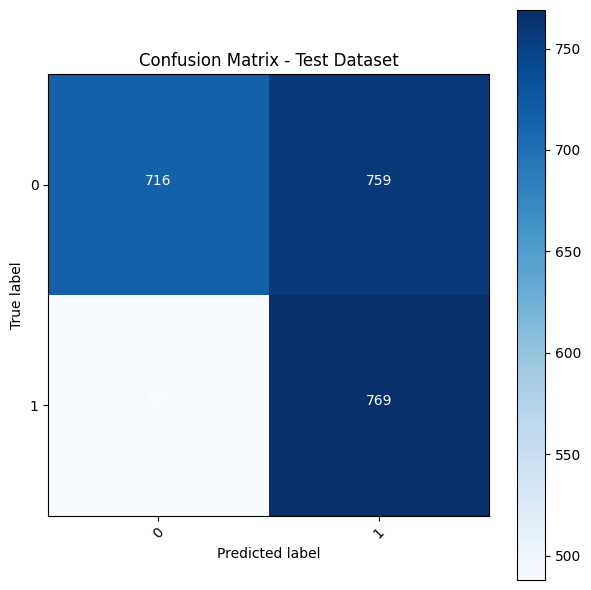

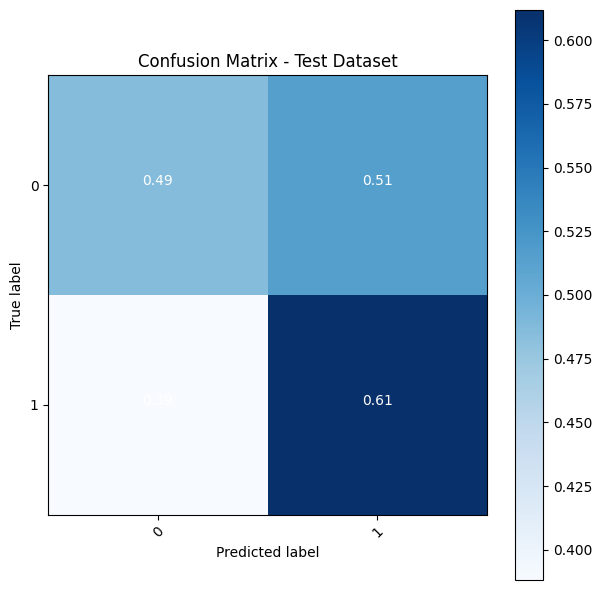

In [125]:
from sklearn.metrics import classification_report, confusion_matrix

cm_test = confusion_matrix(true_values, predicted_values)

np.set_printoptions(precision=2)

plt.figure(figsize=(6,6))
plot_confusion_matrix(cm_test, classes=label_values, title='Confusion Matrix - Test Dataset')
plt.figure(figsize=(6,6))
plot_confusion_matrix(cm_test, classes=label_values, title='Confusion Matrix - Test Dataset', normalize=True)